# Assignment 3  
### Ανατομία του Σθένους στο Spotify

Σκοπός μας είναι να προβλέψουμε το σθένος (valence) ενός τραγουδιού με βάση τα υπόλοιπα χαρακτηριστικά του (danceability, energy, κλπ). Το σθένος ορίζεται ως ένα μέτρο (από 0.0 εως 1.0) της "θετικότητας" ενός τραγουδιού. Όσο πιο μεγαλό είναι (πιο κοντά στο 1) τότε το τραγούδι ακούγεται περισσότερο θετικά (χαρούμενα, με μεγαλύτερη ευφορία) ενώ όσο πιο χαμηλό είναι τότε το τραγούδι έχει έναν περισσότερο "αρνητικό" τόνο (μελαγχολικό).

Θα δοκιμαστούν διάφοροι τρόποι Μηχανικής Μάθησης για την πρόβλεψη του σθένους μιας ομάδας τραγουδιών που θα χρησιμοποιηθεί σαν ομάδα ελέγχου αφού έχει προηγηθεί το training των αλγορίθμων με μια ομάδα δεδομένων training.

Η μεταβλητή "σθένος" είναι συνεχής μεταβλητή επομένως οι μέθοδοι που θα δοκιμαστούν θα είναι παλινδρομήσεις πάνω στα training data. 


Ξεκινάμε με το να δημιουργήσουμε τα training data που θα χρησιμοποιηθούν για το training των μοντέλων μας και τα test data που θα χρησιμοποιηθούν για τον έλεγχο. 

Θα χρησιμοποιήσουμε τα δεδομένα στον φάκελο **Charts** καθώς και πληροφορίες από το **Spotify** για να δημιουργήσουμε το/τα dataframe(s) με τα δεδομένα που θα χρειαστούμε. 

Αρχικά εισάγουμε τις βιβλιοθήκες που θα χρησιμοποιηθούν: 

In [1]:
import pandas as pd
import numpy as np

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Στη συνέχεια δημιουργούμε ένα dataframe με τα data ακολουθώντας τις οδηγίες της εκφώνησης 
(για την μεταβλητή region, το file.split έγινε ως **`region = file.split('\\')[1]`** για να μπορεί να τρέξει σε windows).

In [2]:
header = 0
dfs = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('\\')[1] 
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)

In [3]:
len(all_charts)#.head(2)

273600

Τα μοναδικά τραγούδια είναι:

In [4]:
len(all_charts['song_id'].unique())

13880

Από το Spotify θα πάρουμε τα ακουστικά χαρακτηριστικά των κομματιών. Για τον σκοπό αυτό θα χρησιμοποιούμε το API του Spotify μέσω της βιβλιοθήκης *Spotipy*. Θα σχηματίσουμε ένα λεξικό, features, όπου κλειδί θα είναι το songid και τιμή τα χαρακτηριστικά του, για κάθε τραγούδι. Για να συνδεθούμε στο Spotify έχει δημιουργηθεί ένα αρχείο python, spotify_config, όπου έχουν συμπεριληφθεί τα client_id και client_secret από την εγγραφή στο Spotify development. 
Θα χρησιμοποιηθεί το batch API "Get Tracks' Audio Features" για μεγαλύτερη ευκολία. 

In [5]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
features = {}

Στο λεξικό **features** θα πάρουμε τα δεδομένα από το Spotify:

In [7]:
all_track_ids = list(all_charts['song_id'].unique())
start = 0
num_tracks = 100
while start < len(all_track_ids):
    #print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

len(features)

13880

Ένα παράδειγμα ενός τραγουδιού:

In [8]:
features['5aAx2yezTd8zXrkmtKl66Z'] 

{'danceability': 0.681,
 'energy': 0.594,
 'key': 7,
 'loudness': -7.028,
 'mode': 1,
 'speechiness': 0.282,
 'acousticness': 0.165,
 'instrumentalness': 3.49e-06,
 'liveness': 0.134,
 'valence': 0.535,
 'tempo': 186.054,
 'type': 'audio_features',
 'id': '5aAx2yezTd8zXrkmtKl66Z',
 'uri': 'spotify:track:5aAx2yezTd8zXrkmtKl66Z',
 'track_href': 'https://api.spotify.com/v1/tracks/5aAx2yezTd8zXrkmtKl66Z',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5aAx2yezTd8zXrkmtKl66Z',
 'duration_ms': 230453,
 'time_signature': 4}

Από το λεξικό features δημιουργούμε το dataframe tracks:

In [9]:
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,audio_features,3aQV6E290SJvasp2VOgvBz,spotify:track:3aQV6E290SJvasp2VOgvBz,https://api.spotify.com/v1/tracks/3aQV6E290SJv...,https://api.spotify.com/v1/audio-analysis/3aQV...,140369,4
43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,audio_features,43YQDj1KOPMFAUcTEPKy4p,spotify:track:43YQDj1KOPMFAUcTEPKy4p,https://api.spotify.com/v1/tracks/43YQDj1KOPMF...,https://api.spotify.com/v1/audio-analysis/43YQ...,157520,4
1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,audio_features,1985nAkGJf1oOrgHCWftoN,spotify:track:1985nAkGJf1oOrgHCWftoN,https://api.spotify.com/v1/tracks/1985nAkGJf1o...,https://api.spotify.com/v1/audio-analysis/1985...,125320,4
7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,audio_features,7ntUbTIwmwOD6ygCMRZT6e,spotify:track:7ntUbTIwmwOD6ygCMRZT6e,https://api.spotify.com/v1/tracks/7ntUbTIwmwOD...,https://api.spotify.com/v1/audio-analysis/7ntU...,201271,4


Μετονομάζουμε την στήλη id σε song_id για να μπορέσουμε να ενώσουμε τα dataframes **all_charts** (που δημιουργήθηκε προηγουμένως με τα δεδομένα από το Zenodo) και **tracks** 

In [10]:
tracks = tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
#tracks

Σε μια πρώτη προσέγγιση, η ανάλυση για το σθένος θα βασιστεί στην σχέση του με χαρακτηριστικά όπως danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness και tempo. Ενώνουμε λοιπόν τα δύο dataframes κρατώντας τις στήλες με τα ποιοτικά χαρατκηριστικά για κάθε τραγούδι. 

In [11]:
all_charts = pd.merge(all_charts, tracks[['song_id', 'valence', 'danceability', 'energy', 
                                          'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                                          'instrumentalness','liveness','tempo','duration_ms']], on='song_id', how='left')


all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,...,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,186.054,230453
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,...,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,101.965,251088
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,...,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,95.010,244960
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,...,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,117.973,245200
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,...,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,104.998,222041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273595,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,...,0.652,0,-2.607,1,0.0668,0.10200,0.000000,0.0697,170.024,203093
273596,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,...,0.436,0,-7.269,1,0.0418,0.61800,0.000016,0.3350,104.959,192080
273597,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,...,0.750,11,-6.366,0,0.2310,0.00264,0.000000,0.1090,155.096,182707
273598,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,...,0.792,5,-2.749,1,0.0452,0.19100,0.000000,0.1670,100.015,214290


Παρόλλα αυτά τα μοναδικά τραγούδια εξακολουθούν να είναι 13880

In [12]:
len(all_charts['song_id'].unique())

13880

Στις παρακάτω αναλύσεις δεν μας ενδιαφέρει να δούμε το σθένος ανά χώρα αλλά να το υπολογίσουμε με βάση τα διάφορα άλλα ακουστικά χαρακτηριστικά του κομματιού. Για τον λόγο αυτό θα κρατήσουμε ένα "instance" από κάθε τραγούδι καθώς οι τιμές που μας ενδιαφέρουν θα είναι ίδιες για το ίδιο τραγούδι ανεξαρτήτως χωράς/εβδομάδας/θέση chart κλπ.

In [13]:
all_charts_unique = all_charts.drop_duplicates(subset=['song_id'])
all_charts_unique

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,...,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,186.054,230453
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,...,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,101.965,251088
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,...,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,95.010,244960
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,...,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,117.973,245200
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,...,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,104.998,222041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273386,187,3aQV6E290SJvasp2VOgvBz,What I Please (feat. Denzel Curry),Smokepurpp,1897382,NaN,1,187,new,2019-12-13,...,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,139.970,140369
273516,117,43YQDj1KOPMFAUcTEPKy4p,Millions,Young Thug,2483335,NaN,1,117,new,2019-12-20,...,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,99.027,157520
273561,162,1985nAkGJf1oOrgHCWftoN,Matrix,NLE Choppa,2100003,NaN,1,162,new,2019-12-20,...,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,150.051,125320
273583,184,7ntUbTIwmwOD6ygCMRZT6e,"Writing on the Wall (feat. Post Malone, Cardi ...",French Montana,1973973,NaN,1,184,new,2019-12-20,...,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,112.014,201271


Θα κάνουμε ένα επιπλέον βήμα. Θα εισάγουμε τα στοιχεία των τραγουδιών που θα χρησιμοποιήσουμε για τον έλεγχο. Θα διαβάσουμε το αρχείο **spotify_ids.txt** σε ένα dataframe και θα πάρουμε από το Spotify τα στοιχεία των τραγουδιών του αρχείου

In [14]:
test_data = pd.read_csv("spotify_ids.txt")
test_data

,7lPN2DXiMsVn7XUKtOW1CS
0,5QO79kh1waicV47BqGRL3g
1,0VjIjW4GlUZAMYd2vXMi3b
2,4MzXwWMhyBbmu6hOcLVD49
3,5Kskr9LcNYa0tpt5f0ZEJx
4,6tDDoYIxWvMLTdKpjFkc1B
...,...
1156,4lUmnwRybYH7mMzf16xB0y
1157,1fzf9Aad4y1RWrmwosAK5y
1158,3E3pb3qH11iny6TFDJvsg5
1159,3yTkoTuiKRGL2VAlQd7xsC


Θα ξαναπάρουμε από το Spotify τις πληροφορίες για τα τραγούδια του dataframe **test_data**

In [15]:
test_features = {}
start = 0
num_tracks = 100
while start < len(test_data):
    #print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    test_features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks
    
len(test_features)

1200

Από το λεξικό **test_features** θα δημιουργήσουμε το dataframe **test_tracks**, με τα τραγούδια που θα χρησιμοποιήσουμε για έλεγχο των δοκιμών.

In [16]:
test_tracks = pd.DataFrame.from_dict(test_features, orient='index')
test_tracks = test_tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
test_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.822,0.622,8,-7.330,1,0.3140,0.0347,0.018100,0.1140,0.1800,160.066,audio_features,042nVrQvpEVrsrW6yeeHB2,spotify:track:042nVrQvpEVrsrW6yeeHB2,https://api.spotify.com/v1/tracks/042nVrQvpEVr...,https://api.spotify.com/v1/audio-analysis/042n...,150000,4
1196,0.601,0.724,6,-4.856,1,0.0486,0.0945,0.000002,0.1200,0.5080,102.061,audio_features,4hQ6UGyWQIGJmHSo0J88JW,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,https://api.spotify.com/v1/tracks/4hQ6UGyWQIGJ...,https://api.spotify.com/v1/audio-analysis/4hQ6...,207905,4
1197,0.728,0.690,8,-4.344,0,0.0524,0.0164,0.000000,0.1040,0.4150,94.028,audio_features,1YNQscOx6OqBQjxgJVhEeW,spotify:track:1YNQscOx6OqBQjxgJVhEeW,https://api.spotify.com/v1/tracks/1YNQscOx6OqB...,https://api.spotify.com/v1/audio-analysis/1YNQ...,221153,4
1198,0.601,0.863,0,-4.310,1,0.0685,0.0626,0.000000,0.0717,0.6760,130.189,audio_features,5Z5nbOXhsSbySVC7WUc6y9,spotify:track:5Z5nbOXhsSbySVC7WUc6y9,https://api.spotify.com/v1/tracks/5Z5nbOXhsSby...,https://api.spotify.com/v1/audio-analysis/5Z5n...,312347,4


Στην φάση αυτή έχουμε τα δύο βασικά dataframes που θα χρειαστούμε αργότερα, το **all_charts_unique** που έχει όλα τα δεδομένα από το Zenodo και το Spotify τα οποία θα χρησιμοποήσουμε για το training των μοντέλων, και το **test_tracks** τα δεδομένα του οποίου θα χρησιμοποιηθούν για τον έλεγχο των μοντέλων

In [20]:
all_charts_unique.to_csv('all_charts_unique2.csv')
test_tracks.to_csv('test_tracks2.csv')

# Ε1: Πρόβλεψη Σθένους άνευ Νευρωνικών Δικτύων

## 1η Μέθοδος - Δέντρα αποφάσεων

Θέλουμε να προβλέψουμε την τιμή ενός αριθμητικού μεγέθους, της μεταβλητής "σθενος". Για τον σκόπό αυτό θα χρησιμοποιήσουμε δένδρο αποφάσεων, όπως υλοποιείται από την κλάση *DecisionTreeRegressor* για να υπολογίσουμε μέσω παλινδρόμησης την μεταβλητή που μας ενδιαφέρει σε σχέση με τις υπόλοιπες ανεξάρτητες μεταβλητες. 


Εισάγουμε τις βιβλιοθήκες Μηχανικής Μάθησης που θα χρειαστούμε στη συνέχεια (και για τις άλλες μεθόδους)

In [21]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics

import xgboost as xgb

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\apmou\Downloads\Mathesis\DataScience\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Θα δημιουργήσουμε τα arrays **X_train** και **y_train** που θα χρησιμοποιηθούν στη φάση της προσαρμογής. Για τον σκοπό αυτό, από το dataframe **all_charts_unique** θα κρατήσουμε στο **X_train** μόνο τα χαρακτηριστικά που μας ενδιαφέρουν (τα ποιοτικά χαρακτηριστικά των τραγουδιών βάση των οποίων θα υπολογίσουμε το σθένος) και θα δημιουργήσουμε το **y_train** με την μεταβλητή valence (σθένος).  

In [22]:
DFX_train = all_charts_unique[
                 ['danceability', 
                 'energy',
                 'key', 
                 'loudness', 
                 'mode', 
                 'speechiness', 
                 'acousticness',
                 'instrumentalness',
                 'liveness',
                 'tempo',
                 'duration_ms']
                 ]
X_train = DFX_train.values
#DFX_train.columns[0:]

In [23]:
y_train = all_charts_unique['valence'].values
#y_train

Δημιουργούμε επίσης και τα αντίστοιχα **X_test** και **y_test** από τα δεδομένα ελέγχου. 

In [24]:
DFX_test = test_tracks[
                 ['danceability', 
                 'energy',
                 'key', 
                 'loudness', 
                 'mode', 
                 'speechiness', 
                 'acousticness',
                 'instrumentalness',
                 'liveness',
                 'tempo',
                 'duration_ms'] 
                  ]
X_test = DFX_test.values
#X_test

In [25]:
y_test = test_tracks['valence'].values
#y_test

Για να έχουμε μια αίσθηση της μεταβλητής σθένος στα δεδομένα ελέγχου μπορούμε να χρησιμοποιήσουμε την describe():

In [26]:
test_tracks.valence.describe()

count    1200.000000
mean        0.460940
std         0.212287
min         0.039700
25%         0.295750
50%         0.453000
75%         0.604250
max         0.982000
Name: valence, dtype: float64

Οπότε το σθένος έχει μια μέση τιμή 0,461 και μια τυπική απόκλιση 0,212. Επίσης η μικρότερη τιμή που παίρνει είναι 0.039 και η μεγαλύτερη 0.982 στα τραγούδια του training set. 

Για την φάση της προσαρμογής θα χρησιμοποιούμε έναν `DecisionTreeRegressor`. 

Θα προσπαθήσουμε να βρούμε το βέλτιστο *max_depth* μέσω cross validation των training data. Θα χρησιμοποιήσουμε μια GridSearchCV ορίζοντας *n_splits = 5*, *shuffle=True* και *random_state=13*

In [27]:
parameters = [
  {'max_depth': list(range(1, 30))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
valence_tree_cv = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv) 

valence_tree_cv = valence_tree_cv.fit(X_train, y_train)
print(valence_tree_cv.best_estimator_)
print(valence_tree_cv.best_params_)

DecisionTreeRegressor(max_depth=6)
{'max_depth': 6}


Θα δούμε επίσης και πόσο είναι το ΜΑΕ για *max_depth με range(1,30)* χρησιμοποιώντας cross validation:

In [28]:
cv_plot = []
mae_plot = []

for cv in range(30):
    cv += 1
    valence_tree = DecisionTreeRegressor(max_depth=cv)
    cv_scores = cross_val_score(valence_tree,
                            X_train, 
                            y_train, 
                            cv=KFold(n_splits=5, shuffle=True, random_state=13),
                            scoring="neg_mean_absolute_error",
                            n_jobs=-1)
    cv_plot.append(cv)
    mae_plot.append(-cv_scores.mean())
    print(cv, -cv_scores.mean(), cv_scores.std())


1 0.16895553929354445 0.0008605580804873533
2 0.1642890576346935 0.0010313232398472805
3 0.16101652213676138 0.0009180778741097208
4 0.15886886935642777 0.0011570955019729926
5 0.15751558263921722 0.0009577024524775998
6 0.1563916536269691 0.001313936075771096
7 0.15549911206593506 0.001713986219536871
8 0.15542079494712904 0.002266864869754641
9 0.1565746809902472 0.0018114155720548998
10 0.15818982399573567 0.002450931281020717
11 0.15934065374632303 0.0018192623837780576
12 0.16101588129839944 0.002926145209178752
13 0.1638170389643757 0.0027681689456603683
14 0.16500702330137107 0.0029622037782646776
15 0.16596273186627603 0.0025130961809753756
16 0.16740068652782475 0.0024169525268358722
17 0.16802041349624733 0.002344622429911081
18 0.16774154085079498 0.0022710781157250703
19 0.1688765047529533 0.0021139019556173405
20 0.1697652820173809 0.0023367767815570296
21 0.16960867589100573 0.0025902255569419334
22 0.16888177990771652 0.0025022258678689016
23 0.16946325826349762 0.002350

Στο παρακάτω διάγραμμα βλέπουμε πως αλλάζει το **mean absolute error** σε σχέση με την τιμή **max_depth**:

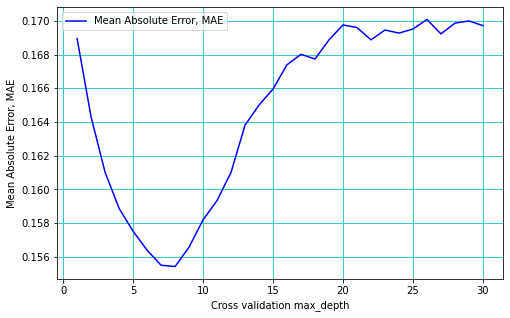

In [29]:
fig = plt.figure(figsize =(8, 5))

plt.plot(cv_plot, mae_plot, color = 'b')
plt.grid(color = 'c')
plt.xlabel("Cross validation max_depth")
plt.ylabel("Mean Absolute Error, MAE")
plt.legend(['Mean Absolute Error, MAE'])  
# Show Plot
plt.show()

Βλέπουμε κι εδώ πως το βέλτιστο max_depth που δίνει το μικρότερο MAE είναι 7. Το δέντρο μας έχει 128 φύλλα:

In [30]:
valence_tree_7 = DecisionTreeRegressor(max_depth=7)
valence_tree_7.fit(X_train, y_train)
valence_tree_7.get_n_leaves()

128

Οι παράμετροι και ο ρόλος που έπαιξαν φαίνονται με το *feature_importances_*. Για το δέντρο με max_depth = 7 θα έχουμε:

In [36]:
importances_tree_7 = valence_tree_7.feature_importances_
feature_names = list(DFX_train.columns)
#importances

#indices_tree_7 = np.argsort(importances_tree_7)[::-1]


for i,v in enumerate(importances_tree_7):
    j = feature_names[i]
    print('Feature: ', j.ljust(17), 'Score: %.5f' % (v))

Feature:  danceability      Score: 0.21743
Feature:  energy            Score: 0.44084
Feature:  key               Score: 0.00195
Feature:  loudness          Score: 0.01454
Feature:  mode              Score: 0.00592
Feature:  speechiness       Score: 0.04265
Feature:  acousticness      Score: 0.07884
Feature:  instrumentalness  Score: 0.05101
Feature:  liveness          Score: 0.05336
Feature:  tempo             Score: 0.04587
Feature:  duration_ms       Score: 0.04760


In [32]:
#feature_names = list(DFX_train.columns)
#print(tree.export_text(valence_tree_5, feature_names=feature_names))

In [61]:
indices_tree_7 = np.argsort(importances_tree_7)[::-1]
#indices_tree

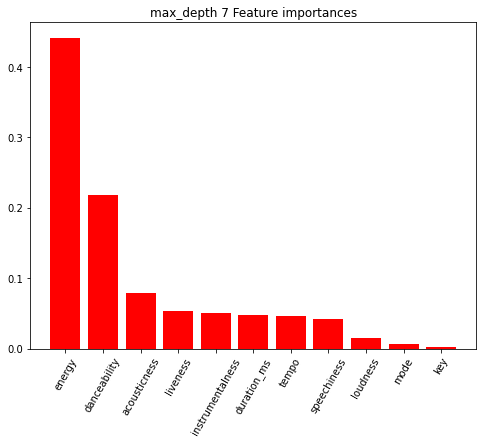

In [62]:
plt.figure(figsize=(8, 6))
plt.title("max_depth 7 Feature importances")
plt.bar(range(len(feature_names)), importances_tree_7[indices_tree_7],
        tick_label=[feature_names[x] for x in indices_tree_7],
        color="r", align="center")
_ = plt.xticks(rotation=60)

Tην μεγαλύτερη συμμετοχή στις "αποφάσεις" του δέντρου τις είχαν οι ενέργεια (*energy*) και χωρευτικότητα (*danceability*) των τραγουδίων, κάτι που εκ πρώτης όψεως φαίνεται λογικό. Γιατί όμως επιλέχτηκαν οι συγκεκριμένοι παράμετροι? Ο λόγος είναι η διακύμανσή τους. Αν δούμε τις διακυμάνεις των επι μέρους παραμέτρων:

In [39]:
DFX_train.var()

danceability        1.999638e-02
energy              2.602999e-02
key                 1.322207e+01
loudness            5.740119e+00
mode                2.491916e-01
speechiness         1.714784e-02
acousticness        5.395731e-02
instrumentalness    3.649924e-03
liveness            2.349449e-02
tempo               7.899682e+02
duration_ms         2.511262e+09
dtype: float64

Φαίνεται ότι οι παράμετροι αυτοί δημιουργούν nodes που έχουν την μεγαλύτερη διακύμανση. 

Μέσω του **GraphViz** μπορούμε να δούμε το δέντρο μας για max_depth=7:

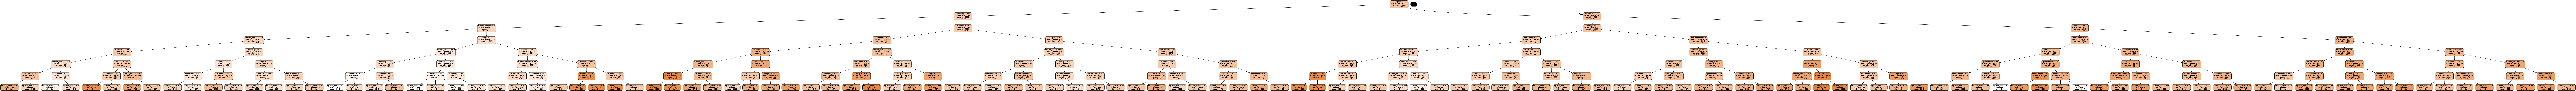

In [40]:
from io import StringIO
from IPython.display import Image  
import pydotplus

import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'


dot_data = StringIO()  
tree.export_graphviz(valence_tree_7, out_file=dot_data,  
                     feature_names=DFX_train.columns[0:],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())  

Το Mean Absolute Error (για τα δεδομένα προσαρμογής) για max_depth=7 όπως είδαμε είναι περίπου 0.156 που είναι μεγάλο για μια μεταβλητή που παίρνει τιμές μεταξύ 0 και 1 (είναι όμως μικρότερο από το std των data ελέγχου). 

Ας δούμε τι προβλέπει το δέντρο για τα δεδομένα ελέγχου.

Για να ελέγξουμε το πως τα πήγαμε, θα χρησιμοποιήσουμε το ξανά το μέσο απόλυτο λάθος (Mean Absolute Error, MAE):

$$ \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|}{n}}$$

για τα δεδομένα ελέγχου πλέον.

In [41]:
valence_predicted_tree = valence_tree_7.predict(X_test)
print(metrics.mean_absolute_error(y_test, valence_predicted_tree))
valence_predicted_tree

0.14271044877269196


array([0.47415922, 0.62870189, 0.45121388, ..., 0.55096849, 0.54202414,
       0.55096849])

Για τα δεδομένα ελέγχου, το MAE έχει υπολογιστεί σε 0,143 

Μπορούμε να δούμε και για πόσα τραγούδια έχουμε διαφορά στην πρόβλεψη, ορίζοντας ένα περιθώριο ανοχής (tolerance) στην διαφορά αυτή. Για παράδειγμα, συγκρίνοντας το array valence_predicted_tree που έχει τις τιμές του σθένους που προέβλεψε το μοντέλο μας για τα τραγούδια ελέγχου, με το array y_test που έχει τις πραγματικές τιμές σθένους των τραγουδιών ελέγχου όπως κατέβηκαν από το Spotify, βρίσκουμε πως μέσα σε ένα περιθώριο ανοχής 0,1 έχουμε 710 τραγούδια που διαφέρουν στην πρόβλεψη για το σθένος.

In [42]:
song_diff = []
tolerance = 0.1
x = valence_predicted_tree - y_test
song_list = x.tolist()
for i in song_list:
    if abs(i) > tolerance:
        song_diff.append(song_list.index(i))

len(song_diff)

710

Για 710 τραγούδια λοιπόν, το σθένος που προβλέπει το μοντέλο μας έχει διαφορά μεγαλύτερη από 0,1 από την πραγματική τιμή. Επομένως για 490 τραγούδια, το σθένος που προέβλεψε το μοντέλο μας είναι μέσα σε ένα περιθώριο +/-0,1 από το πραγματικό σθένος τους. 

Θα μπορούσαμε να δούμε και ποια είναι τα τραγούδια αυτά αν στο dataframe test_tracks υπήρχε και ο τίτλος των τραγουδιών. Θέτωντας ανάλογα το περιθώριο ανοχής, μπορούμε να βρούμε περισσότερα ή λιγότερα τραγούδια να διαφέρουν. 

Ένα ενδιαφέρον γεγονός είναι πως αν δούμε τη σχέση MAE με max_depth για τα δεδομένα ελέγχου έχουμε μια διαφορετική εικόνα:

In [43]:
x_plot = []
y_plot = []

for i in range(30):# [5,10,15,20,25,30,35,40,45,50]:
    i += 1
    valence_tree = DecisionTreeRegressor(max_depth=i)
    valence_tree.fit(X_train, y_train)
    predicted_valence_tree = valence_tree.predict(X_test)
    test_values = (i,metrics.mean_absolute_error(y_test, predicted_valence_tree))
    print(i, metrics.mean_absolute_error(y_test, predicted_valence_tree))
    x_plot.append(i)
    y_plot.append(metrics.mean_absolute_error(y_test, predicted_valence_tree))

1 0.17185513616842707
2 0.1604961822622635
3 0.15739754505388087
4 0.1533017365821054
5 0.1506554727230391
6 0.14746639256220193
7 0.14271044877269196
8 0.136264781208244
9 0.12536111988547438
10 0.1149307547888479
11 0.10211324943468932
12 0.08977152774503727
13 0.07562980654522972
14 0.05969336533710172
15 0.047167416252672914
16 0.038086736288379525
17 0.028538073199476727
18 0.018377570569340914
19 0.012561817491589996
20 0.00880963865862635
21 0.005854334577761209
22 0.003302947865997942
23 0.0020766819182174785
24 0.001421156794772908
25 0.0007289491047881143
26 0.000596793591853043
27 0.00032477633477633484
28 0.00018721106150793656
29 6.0263888888888956e-05
30 1.6666666666666772e-05


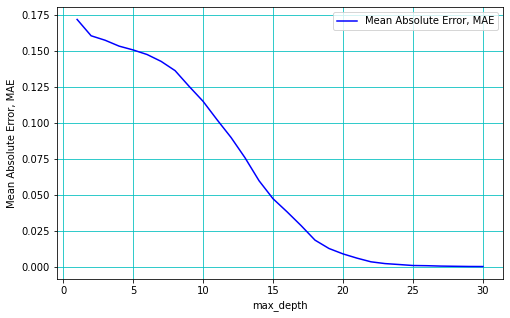

In [44]:
fig = plt.figure(figsize =(8, 5))

plt.plot(x_plot, y_plot, color = 'b')
plt.grid(color = 'c')
plt.xlabel("max_depth")
plt.ylabel("Mean Absolute Error, MAE")
plt.legend(['Mean Absolute Error, MAE'])  
# Show Plot
plt.show()

Βλέπουμε ότι για μια τιμή *max_depth από 20* και πάνω το Mean Absolute Error πέφτει κοντά στο 0. Αυτό όμως σημαίνει ότι έχουμε δημιουργήσει ένα τεράστιο δέντρο. 

Πράγματι για max_depth = 20:

In [45]:
valence_tree_20 = DecisionTreeRegressor(max_depth=20)
valence_tree_20.fit(X_train, y_train)
importances_tree = valence_tree_20.feature_importances_
valence_tree_20.get_n_leaves()


10515

Δηλαδή τα φύλλα του είναι σχεδόν όσα τα training δεδομένα μας!! Ξεκάθαρα γίνεται overfitting των δεδομένων προσαρμογής.  

Παρόλλα αυτά, ένα δέντρο με max_depth = 20, έχει ΜΑΕ πολύ μικρό:

In [46]:
valence_tree_20 = DecisionTreeRegressor(max_depth=20)
valence_tree_20.fit(X_train, y_train)
valence_predicted_20 = valence_tree_20.predict(X_test)
print(metrics.mean_absolute_error(y_test, valence_predicted_20))
#valence_predicted_tree

0.00880963865862635


Και μόνο 28 τραγούδια πλέον διαφέρουν με διαφορά > 0,1 από το πραγματικό σθένος.

In [47]:
song_diff = []
tolerance = 0.1
x = valence_predicted_20 - y_test
song_list = x.tolist()
for i in song_list:
    if abs(i) > tolerance:
        song_diff.append(song_list.index(i))

len(song_diff)

28

Και αν δούμε ποια χαρακτηριστικά έλαβε υπόψιν:

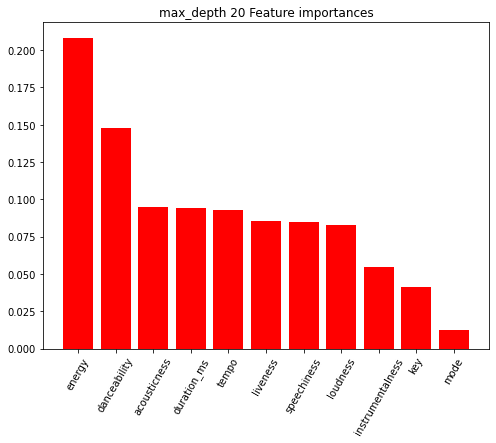

In [63]:
importances_tree_20 = valence_tree_20.feature_importances_

#indices = np.argsort(importances_tree)[::-1]

#for i,v in enumerate(importances_tree):
#    j = feature_names[i]
#    print('Feature: ', j.ljust(17), 'Score: %.5f' % (v))

indices_tree_20 = np.argsort(importances_tree_20)[::-1]
    
plt.figure(figsize=(8, 6))
plt.title("max_depth 20 Feature importances")
plt.bar(range(len(feature_names)), importances_tree_20[indices_tree_20],
        tick_label=[feature_names[x] for x in indices_tree_20],
        color="r", align="center")
_ = plt.xticks(rotation=60)

Βλέπουμε πως και οι υπόλοιπες παράμετροι άρχισαν να συνισφέρουν περισσότερο πλέον στις αποφάσεις του δέντρου. 

## 2η Μέθοδος - Δάση: Απλά, Στοχαστικά, Ακραιώς Στοχαστικά

θα χρησιμοποιήσουμε τώρα δάση από δένδρα αποφάσεων, για να υπολογίσουμε την τιμή του σθένους των τραγουδιών ελέγχου. Πιο πριν χρησιμοποιήσαμε ένα δέντρο αποφάσεων το οποίο *max_depth = 20* υπολόγισε με πολύ μεγάλη ακρίβεια το σθένος της ομάδας ελέγχου, όμως ήταν ξεκάθαρα overfitting καθώς τα φύλλα του ήταν συγκρίσιμα σε αριθμό με τα τραγούδια που χρησιμοποιήθηκαν για την προσαρμογή. 

Με max_depth στο 7 όπως βρέθηκε από τον estimator, το **Mean Absolute Error** ήταν περίπου στο 0,155

Ας θυμηθούμε τα datasets και arrays που θα χρησιμοποιήσουμε:

* **all_charts_unique:** περιέχει όλα τα δεδομένα από το Zenodo και το Spotify  
* **test_tracks:** περιέχει τα δεδομένα που θα χρησιμοποιηθούν για τον έλεγχο των μοντέλων
 
* **DFX_train:** dataframe με τις παραμέτρους (εκτός σθένους) που χρησιμοποιούνται για την προσαρμογή των μοντέλων
* **DFy_train:** dataframe με την παράμετρο του σθένους για την προσαρμογή
* **DFX_test:** dataframe με τις παραμέτρους (εκτός σθένους) που χρησιμοποιούνται για τον έλεγχο των μοντέλων
* **DFy_test:** dataframe με την παράμετρο του σθένους για τον έλεγχο
 
* **X_train:** array με τις τιμές των παραμέτρων (εκτός σθένους) που χρησιμοποιούνται για την προσαρμογή των μοντέλων
* **y_train:** array με τις τιμές της παραμέτρου σθένος για την προσαρμογή 
* **X_test:** array με τις τιμές των παραμέτρων (εκτός σθένους) που χρησιμοποιούνται για τον έλεγχο των μοντέλων
* **y_test:** array με τις τιμές της παραμέτρου σθένος για τον έλεγχο

 Για την υλοποίηση του *δάσους* θα χρησιμοποιήσουμε τους `BaggingRegressor` και `DecisionTreeRegressor`. Θα δούμε πως εξελίσεται η μετρική **Mean Absolute Error** για το cross validation της φάσης της προσαρμογής σε σχέση με τις διάφορες τιμές της υπερπαραμέτρου *estimators*. Για την κατασκευή του ενός δέντρου, θα χρησιμοποιήσουμε *max_depth=7* όπως βγήκε από την προηγούμενη ανάλυση. 

In [50]:
#valence_bagg_tree = DecisionTreeRegressor()
#bagged_cv_scoress = cross_val_score(valence_bagg_tree,
#                            X_train, 
#                            y_train, 
#                            cv=KFold(n_splits=5, shuffle=True),
#                            scoring="neg_mean_absolute_error",
#                            n_jobs=-1)
#print(-cv_scores.mean(), cv_scores.std()) 

In [51]:
from sklearn.ensemble import BaggingRegressor

estimators = [50, 100, 150, 200, 300, 500]

print('Estimators'.ljust(15), 'MAE'.ljust(25), 'std_MAE'.ljust(25))
#for j in n_split:
for i in estimators:
    valence_bagg_tree = BaggingRegressor(DecisionTreeRegressor(max_depth=7),
                                    n_estimators=i, 
                                    n_jobs=-1)
    bagged_cv_scores = cross_val_score(valence_bagg_tree, 
                                   X_train, 
                                   y_train, 
                                   cv=KFold(n_splits=5, shuffle=True, random_state=13),
                                   scoring="neg_mean_absolute_error",
                                   n_jobs=-1)

    print(str(i).ljust(15), str(-bagged_cv_scores.mean()).ljust(25), str(bagged_cv_scores.std()).ljust(25))

Estimators      MAE                       std_MAE                  
50              0.14823612892268592       0.001001165074976184     
100             0.1481557548513144        0.0009597115931108845    
150             0.14819585596986815       0.0008792899686847805    
200             0.1481545405154303        0.0008000700631321282    
300             0.14810552814639272       0.0009266509982861281    
500             0.14803835435902588       0.0009321889037600009    


Εδώ το **Mean Absolute Error** εμφανίζεται λίγο μικρότερο σε σχέση με την προηγούμενη περίπτωση του ενός δέντρου. Θα προχωρήσουμε με την προσαρμογή επιλέγοντας 200 estimators, μιας και η διαφορά μετά στο ΜΑΕ είναι πολύ μικρή.  

In [52]:
valence_bagg_tree = BaggingRegressor(DecisionTreeRegressor(max_depth=7),
                                        n_estimators=200, 
                                        n_jobs=-1)


valence_bagg_tree.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                 n_estimators=200, n_jobs=-1)

In [53]:
importances_bagg = np.mean([tree.feature_importances_ for tree in valence_bagg_tree.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in valence_bagg_tree.estimators_], axis=0)
#importances_bagg

Και η πρόβλεψη του μοντέλου στα δεδομένα ελέγχου: 

In [54]:
valence_bagg_predicted = valence_bagg_tree.predict(X_test)
print("MAE for simple forest:", metrics.mean_absolute_error(y_test, valence_bagg_predicted))
valence_bagg_predicted

MAE for simple forest: 0.13582508295928966


array([0.43878536, 0.57588481, 0.42958245, ..., 0.51509215, 0.56678781,
       0.53501937])

Βλέπουμε πως το **Mean Absolute Error** είναι υψηλότερο από αυτο που υπολογίστηκε με ένα δέντρο και *max_depth = 20* αλλά χαμηλότερο από το δέντρο με *max_depth = 7*

Θα δούμε παρακάτω ποια από τα χαρακτηριστικά θεώρησε ο regressor ποιο σημαντικα:

In [57]:
for i,v in enumerate(importances_bagg):
    j = feature_names[i]
    print('Feature: ', j.ljust(17), 'Score: %.5f' % (v))
#importances

Feature:  danceability      Score: 0.21556
Feature:  energy            Score: 0.41552
Feature:  key               Score: 0.00890
Feature:  loudness          Score: 0.02653
Feature:  mode              Score: 0.00254
Feature:  speechiness       Score: 0.05308
Feature:  acousticness      Score: 0.08121
Feature:  instrumentalness  Score: 0.04583
Feature:  liveness          Score: 0.05943
Feature:  tempo             Score: 0.04071
Feature:  duration_ms       Score: 0.05070


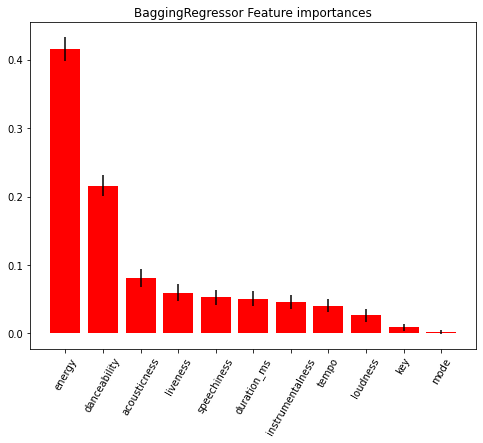

In [64]:
indices_bagg = np.argsort(importances_bagg)[::-1]
plt.figure(figsize=(8, 6))
plt.title("BaggingRegressor Feature importances")
plt.bar(range(len(feature_names)), importances_bagg[indices_bagg],
        tick_label=[feature_names[x] for x in indices_bagg],
        color="r", yerr=std[indices_bagg], align="center")
_ = plt.xticks(rotation=60)

Βλέπουμε πως παρουσιάζεται περίπου η ίδια εικόνα σε σχέση με το απλό δέντρο με max_depth=7

In [65]:
#song_bagg_diff = []
#tolerance = 0.01
#x = valence_bagg_predicted - y_test
#song_bagg_list = x.tolist()
#for i in song_bagg_list:
#    if abs(i) > tolerance:
#        song_bagg_diff.append(song_bagg_list.index(i))

#len(song_bagg_diff)

 * ###  Στοχαστικά δάση

Θα χρησιμοποιήσουμε τον **RandomForestRegressor** για να υπολογίσουμε το σθένος. Θα δούμε ξανά για διάφορες τιμές της υπερπαραμέτρου *n_estimators* πως εξελίσσεται το MAE για το cross validation της φάσης της προσαρμογής. 

In [67]:
#valence_rand_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1)
#forest_cv_scores = cross_val_score(valence_rand_forest,  
#                                    X_train, 
#                                    y_train,
#                                    cv=KFold(n_splits=5, shuffle=True),
#                                    scoring="neg_mean_absolute_error",
#                                    n_jobs=-1)
#print(-forest_cv_scores.mean(), forest_cv_scores.std())


estimators = [50, 100, 150 ,200, 300]
#n_split = [5, 10]

print('Estimators'.ljust(15), 'MAE'.ljust(25), 'std_MAE'.ljust(25))
#for j in n_split:
for i in estimators:
    valence_rand_forest = RandomForestRegressor(max_depth=7, n_estimators=i, n_jobs=-1)
    random_cv_scores = cross_val_score(valence_rand_forest, 
                               X_train, 
                               y_train, 
                               cv=KFold(n_splits=5, shuffle=True),
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1)

    print(str(i).ljust(15), str(-random_cv_scores.mean()).ljust(25), str(random_cv_scores.std()).ljust(25))





Estimators      MAE                       std_MAE                  
50              0.14812111366995978       0.0012574221515687508    
100             0.14825463022906643       0.0021951135002572604    
150             0.14812582965249982       0.00251689577714045      
200             0.14805380558739684       0.0012855108906003202    
300             0.1480900715120225        0.0013413520265023512    


Κάνουμε προσαρμογή του μοντέλου με τα δεδομένα προσαρμογής:

In [68]:
valence_rand_forest = RandomForestRegressor(max_depth=7, n_estimators=200, 
                                        n_jobs=-1)


valence_rand_forest.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=200, n_jobs=-1)

 Ας δούμε ποιες παραμέτρους θεώρησε ο regressor πιο σημαντικά:

In [69]:
importances_rand = valence_rand_forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in valence_rand_forest.estimators_], axis=0)
indices_rand = np.argsort(importances_rand)[::-1]

#for i in indices_rand:
#    print(X_train[i], importances_rand[i])

In [70]:
for i,v in enumerate(importances_rand):
    j = feature_names[i]
    print('Feature: ', j.ljust(17), 'Score: %.5f' % (v))

Feature:  danceability      Score: 0.21762
Feature:  energy            Score: 0.41492
Feature:  key               Score: 0.00880
Feature:  loudness          Score: 0.02645
Feature:  mode              Score: 0.00240
Feature:  speechiness       Score: 0.05373
Feature:  acousticness      Score: 0.08044
Feature:  instrumentalness  Score: 0.04382
Feature:  liveness          Score: 0.05910
Feature:  tempo             Score: 0.04104
Feature:  duration_ms       Score: 0.05169


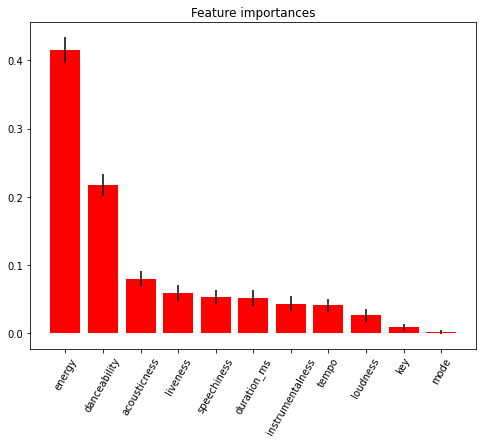

In [71]:
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(feature_names)), importances_rand[indices_rand],
        tick_label=[feature_names[x] for x in indices_rand],
        color="r", yerr=std[indices_rand], align="center")
_ = plt.xticks(rotation=60)

Σχεδόν ίδια εικόνα όπως προηγουμένως. Και το MAE για τα δεδομένα της πρόβλεψης: 

In [73]:
valence_rand_predicted = valence_rand_forest.predict(X_test)
print("MAE for random forest:", metrics.mean_absolute_error(y_test, valence_rand_predicted))
valence_rand_predicted

MAE for random forest: 0.13632675906101857


array([0.44195155, 0.56912219, 0.42374514, ..., 0.51567343, 0.57595695,
       0.53447447])

In [74]:
#song_rand_diff = []
#tolerance = 0.01
#x = valence_rand_predicted - y_test
#song_rand_list = x.tolist()
#for i in song_rand_list:
#    if abs(i) > tolerance:
#        song_rand_diff.append(song_rand_list.index(i))

#len(song_rand_diff)

* ### Ακραιως στοχαστικα δαση

Αντίστοιχα για ακραίο στοχαστικό δάσος:

In [75]:
estimators = [50, 100, 150 ,200, 300]
#n_split = [5, 10]

print('Estimators'.ljust(15), 'MAE'.ljust(25), 'std_MAE'.ljust(25))
#for j in n_split:
for i in estimators:
    valence_extr_forest = ExtraTreesRegressor(n_estimators=i, n_jobs=-1)
    extr_cv_scores = cross_val_score(valence_extr_forest, 
                               X_train, 
                               y_train, 
                               cv=KFold(n_splits=5, shuffle=True),
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1)

    print(str(i).ljust(15), str(-extr_cv_scores.mean()).ljust(25), str(extr_cv_scores.std()).ljust(25))

#valence_extr_forest = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)

#extremely_cv_scores = cross_val_score(valence_extr_forest, 
#                                      X_train,
#                                      y_train, 
#                                      cv=KFold(n_splits=5, shuffle=True),
#                                      scoring="neg_mean_absolute_error",
#                                      n_jobs=-1)
#print(-extremely_cv_scores.mean(), extremely_cv_scores.std())

Estimators      MAE                       std_MAE                  
50              0.12419762132564845       0.002342935928149943     
100             0.12397562730547555       0.0019370428443943341    
150             0.12373050408261295       0.0013264881924982988    
200             0.12364388292507215       0.0009634118029040168    
300             0.12342773729586953       0.0011199113096602303    


Και ξανά για το ποιες παράμετροι θεωρήθηκαν σημαντικές: 

Feature:  danceability      Score: 0.24347
Feature:  energy            Score: 0.55477
Feature:  key               Score: 0.00744
Feature:  loudness          Score: 0.05036
Feature:  mode              Score: 0.01137
Feature:  speechiness       Score: 0.01874
Feature:  acousticness      Score: 0.05166
Feature:  instrumentalness  Score: 0.00955
Feature:  liveness          Score: 0.01686
Feature:  tempo             Score: 0.01353
Feature:  duration_ms       Score: 0.02225


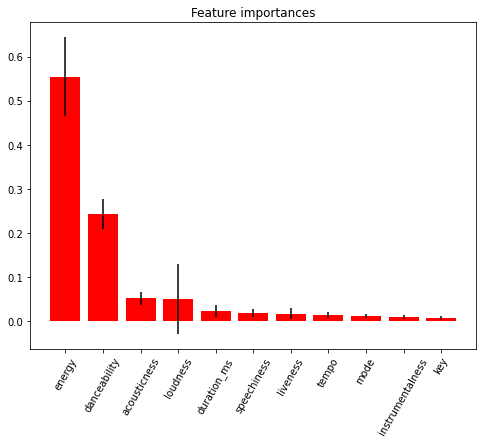

In [76]:
valence_extr_forest = ExtraTreesRegressor(max_depth=7, n_estimators=100, n_jobs=-1)
valence_extr_forest.fit(X_train, y_train)
importances_extr = valence_extr_forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in valence_extr_forest.estimators_], axis=0)
indices_extr = np.argsort(importances_extr)[::-1]

for i,v in enumerate(importances_extr):
    j = feature_names[i]
    print('Feature: ', j.ljust(17), 'Score: %.5f' % (v))

plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(feature_names)), importances_extr[indices_extr],
        tick_label=[feature_names[x] for x in indices_extr],
        color="r", yerr=std[indices_extr], align="center")
_ = plt.xticks(rotation=60)  

In [77]:
valence_extr_predicted = valence_extr_forest.predict(X_test)
print('ΜΑΕ for extreme forests: ', metrics.mean_absolute_error(y_test, valence_extr_predicted))
valence_extr_predicted

ΜΑΕ for extreme forests:  0.14788429149117893


array([0.44928008, 0.59285907, 0.45245526, ..., 0.52567087, 0.56400028,
       0.50587683])

In [78]:
y_test

array([0.535, 0.742, 0.661, ..., 0.415, 0.676, 0.648])

Συμπερασματικά, για το ΜΑΕ οπως υπολογίστηκε με τα 3 διαφορετικά μοντέλα δασών έχουμε

In [79]:
bagg_MAE = metrics.mean_absolute_error(y_test, valence_bagg_predicted)
rand_MAE = metrics.mean_absolute_error(y_test, valence_rand_predicted)
extr_MAE = metrics.mean_absolute_error(y_test, valence_extr_predicted)

print('Simple_Forest'.ljust(25), 'Random_Forest'.ljust(25), 'Extremely_Random_Forest'.ljust(25))
print(str(bagg_MAE).ljust(25), str(rand_MAE).ljust(25), str(extr_MAE).ljust(25))

Simple_Forest             Random_Forest             Extremely_Random_Forest  
0.13582508295928966       0.13632675906101857       0.14788429149117893      


# 3η Μέθοδος - Boosters 

Με χρήση του XGBoost classifier

In [80]:
xgb_reg = xgb.XGBRegressor()

scores = cross_val_score(xgb_reg, 
                         X_train, 
                         y_train, 
                         scoring="neg_mean_absolute_error", 
                         cv=KFold(n_splits=15, shuffle=True),
                         n_jobs=-1)

In [81]:
print(-scores.mean(), scores.std())

0.13873505190769678 0.00233686321142213


Μπορούμε όπως και πριν, αφού εκπαιδεύσουμε το μοντέλο στα δεδομένα μας, να δούμε τη σημαντικότητα των χαρακτηριστικών.

In [82]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

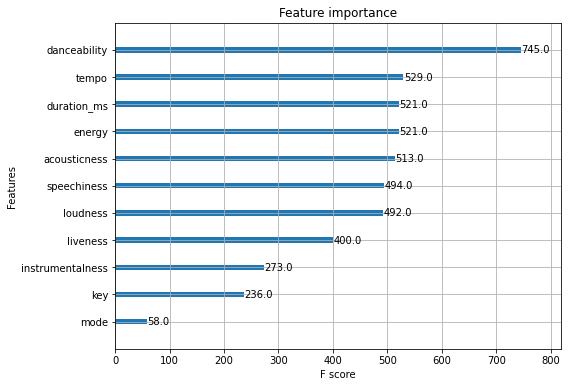

In [83]:
fig = plt.figure(figsize=(8, 6))
xgb_reg.get_booster().feature_names = feature_names
xgb.plot_importance(xgb_reg, ax = fig.gca())

Εδώ παρατηρούμε μια διαφορά στο ποιες παράμετροι έπαιξαν τον μεγαλύτερο ρόλο. Παρατηρούμε πως η danceability είναι πλέον πρώτη και ακολουθεί το tempo. 

In [85]:
# make predictions for test data
y_pred = xgb_reg.predict(X_test)
print('MΑΕ for XGBoost: ', metrics.mean_absolute_error(y_test, y_pred))
y_pred




MΑΕ for XGBoost:  0.085226933201164


array([0.470784  , 0.61473244, 0.5350951 , ..., 0.5545031 , 0.61145204,
       0.572317  ], dtype=float32)

In [86]:
#_diff = []
#tolerance = 0.01
#x = y_pred - y_test
#_list = x.tolist()
#for i in _list:
#    if abs(i) > tolerance:
#        _diff.append(_list.index(i))
#len(_diff)

## AdaBoost

Με χρήση του AdaBoostClassifier

In [87]:
from sklearn.ensemble import AdaBoostRegressor

clf = DecisionTreeRegressor(max_depth=7)
valence_ada_boost_rgr = AdaBoostRegressor(clf, n_estimators=200)
ada_boost_cv_scores = cross_val_score(valence_ada_boost_rgr, 
                                      X_train,
                                      y_train,
                                      cv=KFold(n_splits=5, shuffle=True),
                                      scoring="neg_mean_absolute_error",
                                      n_jobs=-1)
print(-ada_boost_cv_scores.mean(), ada_boost_cv_scores.std())

0.15173066391369078 0.0013834989275396462


In [88]:
clf = DecisionTreeRegressor()
valence_ada_boost_rgr = AdaBoostRegressor(clf, n_estimators=50)
valence_ada_boost_rgr.fit(X_train, y_train)
importances_ada = valence_ada_boost_rgr.feature_importances_

std = np.std([tree.feature_importances_ for tree in valence_ada_boost_rgr.estimators_], axis=0)
indices_ada = np.argsort(importances_ada)[::-1]

for i in indices_ada:
    print(feature_names[i], importances_ada[i])

energy 0.15562415171325533
danceability 0.1334103169156739
acousticness 0.10657385095415646
tempo 0.10080305817769632
speechiness 0.100216180710013
liveness 0.09957033217038624
duration_ms 0.09848851600669721
loudness 0.09595247003081231
instrumentalness 0.05150453137647732
key 0.046438582317841336
mode 0.011418009626990676


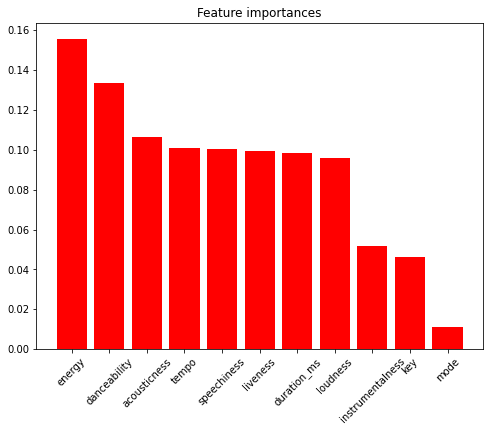

In [89]:
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(feature_names)), importances_ada[indices_ada],
        tick_label=[feature_names[x] for x in indices_ada],
        color="r", align="center")
_ = plt.xticks(rotation=45)

# Ε2: Πρόβλεψη Σθένους με χρήση Νευρωνικών Δικτύων

Θα επιχειρήσουμε να προβλέψουμε το σθένος των τραγουδιών ελέγχου με χρήση Νευρωνικών Δικτύων. 

In [90]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

tf.random.set_seed(0) # for replicability purposes, not for production

Πρώτα θα κανονικοποιήσουμε τα δεδομένα περνώντας τα από έναν normalizer.



In [91]:
normalizer = layers.Normalization()
normalizer.adapt(np.array(X_train))
with np.printoptions(precision=2):
    print(normalizer.mean.numpy())
    print(normalizer.variance.numpy())
    print(normalizer.count.numpy()) 

[[ 6.87e-01  6.66e-01  5.35e+00 -6.30e+00  5.29e-01  1.54e-01  2.49e-01
   7.92e-03  1.82e-01  1.22e+02  2.07e+05]]
[[2.00e-02 2.60e-02 1.32e+01 5.74e+00 2.49e-01 1.71e-02 5.40e-02 3.65e-03
  2.35e-02 7.90e+02 2.51e+09]]
13880


Θα ξεκινήσουμε με το να δούμε ποιες υπερπαράμετροι του μοντέλου μας είναι οι πιο κατάλληλες για τον υπολογισμό που θέλουμε. Θα ορίσουμε τον αλγόριθμο βελτιστοποίησης (optimizer) και θα χρησιμοποιήσουμε τη Στοχαστική Κάθοδο Κλίσης (Stochastic Gradient Descent).

Αρχικά θα ξεκινήσουμε με ένα layer 11 νευρώνων μιας και 11 είναι οι παράμετροι στις οποίες θα βασιστούμε για να υπολογίσουμε το σθένος. 

Δεν δίνουμε συνάρτηση ενεργοποίησης στο στρώμα εξόδου αφού θέλουμε να προβλέψουμε την τιμή του σθένους, άρα θέλουμε να πάρουμε το αποτέλεσμα του νευρώνα χωρίς να το υποχρεώνουμε να είναι σε κάποια όρια τιμών.

Την απώλεια θα την μετράμε κι εδώ με βάση το Μέσο Απόλυτο Λάθος.


In [92]:
model = keras.Sequential([
        normalizer,
        layers.Dense(11, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

Ας δούμε συνοπτικά το μοντέλο μας.

Έχουμε παραμέτρους που δεν εκπαιδεύονται: είναι οι μέσοι όροι, οι διακυμάνσεις, και ο αριθμός των στοιχείων που έχει ήδη βρει το επίπεδο Normalization.

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 1)                 12        
                                                                 
Total params: 167
Trainable params: 144
Non-trainable params: 23
_________________________________________________________________


Θα εκπαιδεύσουμε το μοντέλο μας για 100 εποχές.

Σε κάθε εποχή τα τελευταία 20% των δεδομένων θα χρησιμοποιούνται για επικύρωση.

Θα δηλώσουμε την παράμετρο early_stop ώστε να μην χρεάζεται να εκπαιδεύουμε το μοντέλο μας περισσότερες εποχές από όσες χρειάζεται

Θα αποθηκεύσουμε την πορεία της εκπαίδευσης σε μία μεταβλητή history.

In [94]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

num_epochs = 20

history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1)#,
    #callbacks=[early_stop])

Epoch 1/20
347/347 [==============================] - 1s 2ms/step - loss: 0.2977 - val_loss: 0.1966
Epoch 2/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1735 - val_loss: 0.1631
Epoch 3/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1593 - val_loss: 0.1554
Epoch 4/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1554 - val_loss: 0.1572
Epoch 5/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1540 - val_loss: 0.1527
Epoch 6/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1531 - val_loss: 0.1526
Epoch 7/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1525 - val_loss: 0.1522
Epoch 8/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1520 - val_loss: 0.1535
Epoch 9/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1514 - val_loss: 0.1528
Epoch 10/20
347/347 [==============================] - 1s 2ms/step - loss: 0.1511 - val_loss: 0.1532

Η πορεία της εκπαίδευσης μας δείχνει την πρόοδο στην απώλεια εκπαίδευσης και στην απώλεια επικύρωσης, σε κάθε εποχή.

In [95]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,0.297722,0.196608,0
1,0.173539,0.163128,1
2,0.159334,0.155379,2
3,0.155414,0.157217,3
4,0.154037,0.152681,4
5,0.153146,0.152584,5
6,0.152476,0.152203,6
7,0.151955,0.153490,7
8,0.151381,0.152772,8
9,0.151128,0.153214,9


Μπορούμε να δούμε την εξέλιξη αν φτιάξουμε μια βοηθητική συνάρτηση για την απεικόνιση.

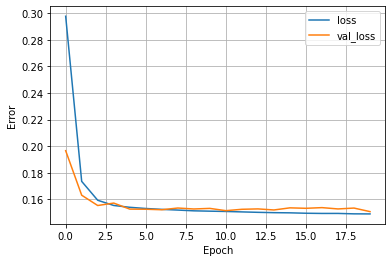

In [96]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

Βλέπουμε ότι η απώλεια στην επικύρωση δεν αποκλίνει και πολύ από την απώλεια εκπαίδευσης αλλά υπάρχει κάποια απόκλιση.

#Αυτό μπορεί να είναι δείγμα υπερπροσαρμογής.


Αξιολογούμε το μοντέλο μας με βάση τα δεδομένα ελέγχου.

In [97]:
metrics = model.evaluate(X_test, y_test, verbose=0)

#metrics = model.evaluate(X_test, y_test, verbose=0)
#for metric_name, metric in zip(model.metrics_names, metrics):
#    print(metric_name, metric)
print(metrics, model.metrics_names)

0.14586126804351807 ['loss']


Και προχωράμε στην πρόβλεψη:

In [98]:
valence_pred  = model.predict(X_test)

valence_pred

array([[0.46797678],
       [0.55710196],
       [0.4202946 ],
       ...,
       [0.4637547 ],
       [0.4768176 ],
       [0.41924   ]], dtype=float32)

Βλέπουμε πως το MAE για τα πραγματικά δεδομένα δεν διαφέρει και πολύ από αυτό για τα training δεδομένα. 

In [99]:
from sklearn.metrics import mean_absolute_error as mae
accuracy = mae(valence_pred, y_test)
accuracy

0.14586127259723344

In [1]:
# Linear regressor

In [2]:
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_absolute_error

#model = LinearRegression()
#model.fit(X_train, y_train)

#y_pred_linear = model.predict(X_test)

#linearMAE=mean_absolute_error(y_pred_linear, y_test)
#linearMAE

In [3]:
#print(model.coef_)
#print(model.n_features_in_)
#print(model.feature_names_in_)
#model.score(X_test, y_test)
#model.get_params()